# Project 3: Movie Recommendations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing Data

Setting up variables for that hold the paths to the various data files. The data files don't have a header row, so explicitly defining the column names based on the README file that came with the data.

In [2]:
PARENT_DIR = "data/ml-1m/"
ratings_path = PARENT_DIR + "ratings.dat"
movies_path = PARENT_DIR + "movies.dat"
users_path = PARENT_DIR + "users.dat"

ratings_col_names = ["UserID", "MovieID", "Rating", "Timestamp"]
movies_col_names = ["MovieID", "Title", "Genres"]
users_col_names = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]

Import the data using pandas into separate data frames.

In [3]:
# setting engine to python to avoid a warning when using regex delimiter
# change encoding to fix error that was occurring due to certain characters in movie titles not having utf-8 encoding such as
# the letter é
ratings_df = pd.read_csv(ratings_path, sep="::", engine='python', names=ratings_col_names)
movies_df = pd.read_csv(movies_path, sep="::", engine='python', encoding='ISO-8859-1', names=movies_col_names)
users_df = pd.read_csv(users_path, sep="::", engine='python', names=users_col_names)

Do a quick santiy check to see if the data was loaded correctly

In [5]:
print("Shape: ", ratings_df.shape)
ratings_df.head()

Shape:  (1000209, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
print("Shape: ", movies_df.shape)
movies_df.head()

Shape:  (3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
print("Shape: ", users_df.shape)
users_df.head()

Shape:  (6040, 5)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Preprocessing


In [8]:
# TODO: May need to do some joins and stuff on the data here. Not sure yet what is required for the following parts.

## Data Exploration

In [9]:
## May not need this section. But just adding it in case

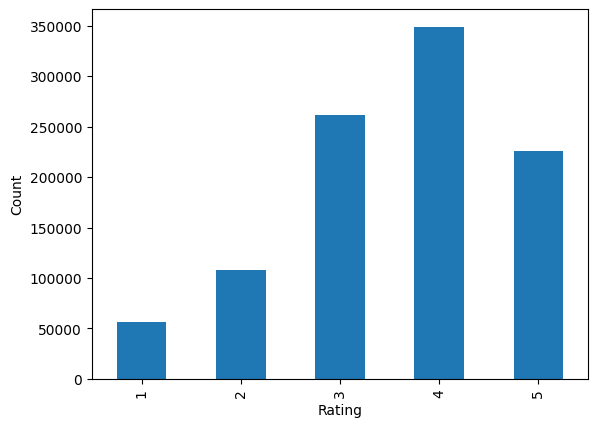

In [10]:
counts = ratings_df["Rating"].value_counts().sort_index()
counts.plot(kind="bar")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## Part A

**Recommend the top 10 “most popular” movies. The term “most popular” is open
to interpretation from each group. So, it is important to clearly state how you define the
popularity of a movie. The recommendation you make should display the top 10 movie
titles, and information related to the criteria you used - e.g. if you recommend the top 10
movies based on ratings for movies with at least 1,000 ratings, report these numbers.**

We decided to use the given example definition for the top 10 "most popular" movies. Specifically, we define it as the top rated movies with at least 1000 ratings.

In order to do so, we begin by first creating 2 new auxiliary columns to help us with our analysis: `NumRatings` and `AvgRating`. `NumRatings` is number of times that the movie in the `MovieID` column was rated. The `AvgRating` is the average rating of the movie in the `MovieID` column across all of provided ratings.

In [18]:
ratings_by_movie = ratings_df.groupby('MovieID')
ratings_df['NumRatings'] = ratings_by_movie['MovieID'].transform('count')
ratings_df['AvgRating'] = ratings_by_movie['Rating'].transform('mean')

# Sanity checks
assert(ratings_df.drop_duplicates('MovieID')['NumRatings'].sum() == ratings_df.shape[0])
assert(ratings_df["AvgRating"].between(0, 5).all())

Now, we remove any unncessary columns for our analysis and drop any duplicate movies since we have those auxiliary columns already computed

In [19]:
# Drop UserID and Timestamp since we don't need these to determine the most popular movies. Rating can be removed since we will use the AvgRating.
popular_movies = ratings_df.drop(columns=["UserID", "Timestamp", "Rating"])
# We will be filtering using NumRatings at some point. But duplicate movies will have the same "NumRatings" 
# so we need to drop duplicates
popular_movies = popular_movies.drop_duplicates('MovieID')

To satisfy our curiosity and pick a good threshold for the number of ratings, we plot a distributions of the `NumRatings` column

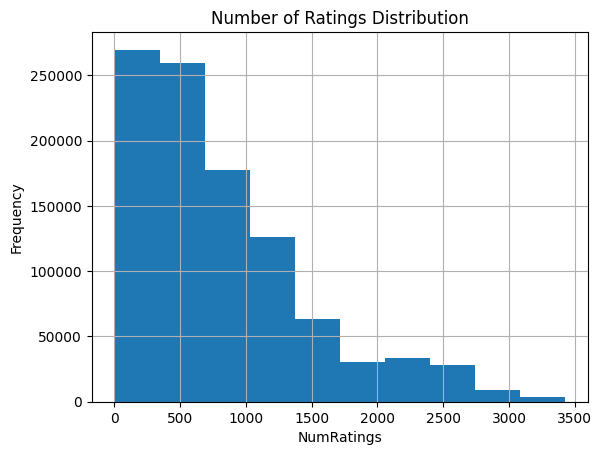

In [13]:
ratings_df["NumRatings"].hist(bins=10)
plt.xlabel("NumRatings")
plt.ylabel("Frequency")
plt.title("Number of Ratings Distribution")
plt.show()

Now, we filter our dataset to only include movies that have been rated at least 1000 times.

In [15]:
# Let's do an initial filter for ratings that at least have 1000 ratings
threshold = 1000
popular_movies = popular_movies[popular_movies['NumRatings'] >= threshold]
popular_movies.shape

(207, 3)

We can now filter for the top 10 movies with the highest average rating

In [20]:
top10 = popular_movies.nlargest(10, "AvgRating")
print(top10.columns)
print(top10)

Index(['MovieID', 'NumRatings', 'AvgRating'], dtype='object')
        MovieID  NumRatings  AvgRating
6448       3280           1        5.0
19836       787           3        5.0
322947      989           1        5.0
465274     1830           1        5.0
467956     3881           1        5.0
558160     3233           2        5.0
568059     3172           1        5.0
879590     3656           1        5.0
883623     3382           1        5.0
970914     3607           1        5.0


Finally, we get the names corresponding to the resulting MovieID's

In [17]:
# Get back the names of these 10 movies based on the ID

top10 = top10.merge(movies_df[["MovieID", "Title"]], on="MovieID", how="left")
top10

,MovieID,NumRatings,AvgRating,Title
0,318,2227,4.554558,"Shawshank Redemption, The (1994)"
1,858,2223,4.524966,"Godfather, The (1972)"
2,50,1783,4.517106,"Usual Suspects, The (1995)"
3,527,2304,4.510417,Schindler's List (1993)
4,1198,2514,4.477725,Raiders of the Lost Ark (1981)
5,904,1050,4.476190,Rear Window (1954)
6,260,2991,4.453694,Star Wars: Episode IV - A New Hope (1977)
7,750,1367,4.449890,Dr. Strangelove or: How I Learned to Stop Worr...
8,912,1669,4.412822,Casablanca (1942)
9,2762,2459,4.406263,"Sixth Sense, The (1999)"


The above shows the top 10 most "popular" movies where popular is defined as the movies that have atthe highest average rating

## Part B

Make a recommendation based on Item-Based Collaborative Filtering (IBCF) by
writing your own IBCF function following the steps below:

### 1. 

Create the rating matrix by R, where the rows correspond to users and the columns
to movies. Normalize R by centering each row, i.e. subtract the row means from
each row of the matrix. The matrix is sparse, so the row means should be computed
based on the non-NA entries.

### 2
Compute the cosine similarity for all the movies. You can ignore similarities computed based on less than 3 user ratings. You can also use the (1 + cos)/2 transformation to ensure than the similarity will be between 0 and 1. Keep in mind that
you may have NAs when a pair off movies (for example) has been rated by 0, 1, or
2 users, or when the denominator in the similarity metric is zero.

### 3.
For the similarity matrix in (2), sort the non-NA similarity measures and keep the
top 30, setting the rest to NA. Display the pairwise similarity values for this new
matrix for the following movies:
• “Toy Story (1995)”
• “GoldenEye (1995)”
• “Liar Liar (1997)”
• “Lost World: Jurassic Park (1997)”
• “Sixth Sense, The (1999)”

### 4.
Write your own IBCF function:

• Input: newuser, i.e. a vector containing ratings for all the movies.
Many of the entries will be NA, while the non-NA values should be ratings 1, 2,
3, 4, 5 - the star ratings.

• Output: The top 10 movies recommendation for this new user.
If fewer than 10 predictions are non-NA, select the remaining movies based on
the popularity defined in part (A), prioritizing the most popular ones and excluding those already rated by the user. Here, you may want to save the ranking
of all movies (based on popularity) in a separate file to avoid recomputing the
ranking each time.

• The function you write should load the similarity matrix and use it to compute
predictions for movies that have not been rated by the new user yet, using the
formula from the notes/slides.

### 5.

Test your function by displaying the top 10 recommendations for the following two
users:

• User in row 1500 from the rating matrix.

• A hypothetical user who rates movie “Star Wars: Episode IV - A New Hope
(1977)” with 5 stars and movie “Independence Day (ID4) (1996)” with 4 stars.